In [34]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re,string,unicodedata
from collections import Counter

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.models import model_from_json
from keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns

import contractions 

from sklearn import metrics 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download()
nltk.download('stopwords')

lista_stopwords = set(stopwords.words('english'))
punctuation = list(string.punctuation)
lista_stopwords.update(punctuation)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gdutr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def mostra_relacao_ngrams_sentimento(features, feature_names, labels, labels_dict, ngrams=3, N=3):
    
    for sentiment, sentiment_id in sorted(labels_dict.items()):
        features_chi2 = chi2(features, labels == sentiment_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(feature_names)[indices] # vectorizer.get_feature_names()
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    
        print("# '{}':".format(sentiment))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
        print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

In [36]:
text = '''I'll be there within 5 min. Shouldn't you be there too?  
          I'd love to see u there my dear. It's awesome to meet new friends. 
          We've been waiting for this day for so long.'''
text = contractions.fix(text)
print(text)

I will be there within 5 min. should not you be there too?  
          I would love to see you there my dear. it is awesome to meet new friends. 
          we have been waiting for this day for so long.


### Rotina Pré-Processamento (Representação por Frequência)

In [63]:
# separa tokens por representação vetorial
def split_tokens_word_freq(texto, use_twitter_tokenizer=True,use_lemmatizer=True):
    lemmatizer = WordNetLemmatizer()
    texto = texto.lower()
    texto = contractions.fix(texto)    
    
    if use_twitter_tokenizer:
        tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
        lista_tokens_inicial = tokenizer.tokenize(texto)
    else:
        lista_tokens_inicial = word_tokenize(texto)
    
    lista_tokens = []
    if use_lemmatizer:
        for token in lista_tokens_inicial:
            token = lemmatizer.lemmatize(token)
            if (token not in lista_stopwords):
                lista_tokens.append(token)
    
    return lista_tokens

In [5]:
def limpa_texto(texto):
    # link
    texto = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', texto)
    # numero string com números não estamos retirando inicialmente (COVID-19)
    texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'number', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto

In [6]:
def get_labels_dict(lista_sentimentos):
    ret = {}
    for pos,sentimento in enumerate(lista_sentimentos):
        ret[sentimento] = pos
    return ret
    

In [7]:
def carrega_tokens_word_freq(lista_texto, use_twitter_tokenizer=True):
    dados_tokens = []
    for texto in lista_texto:
        texto_limpo = limpa_texto(texto)
        tokens_add = split_tokens_word_freq(texto_limpo, use_twitter_tokenizer)
        dados_tokens.append(tokens_add)

    dados_tokens = np.asarray(dados_tokens)
    return dados_tokens

In [ ]:
#dados - panda; 
def pre_processamento_word_freq(dados_pd, use_twitter_tokenizer=True):
    
    lista_sentimentos = dados_pd.Sentiment.unique()
    lista_sentimentos.sort()
    label_dict = get_labels_dict(lista_sentimentos)
    labels = [label_dict[label] for label in dados_pd.Sentiment]
    labels = np.asarray(labels)
        
    feature_tokens = carrega_tokens_word_freq(dados_pd.OriginalTweet, use_twitter_tokenizer)
    
    words_lower_impact = get_words_with_lower_impact(.15, feature_tokens, labels, label_dict)
    print(words_lower_impact)
    
    feature_str = []
    for f_token in feature_tokens:
        linha = " ".join([token for token in f_token if token not in words_lower_impact and len(token) > 1])
        feature_str.append(linha)
    feature_str = np.asarray(feature_str)
    
    
    
    return feature_str, labels, label_dict

In [9]:
def get_word_frequency_by_label(min_frequency, features,labels,label_filter):
    vet = [features[i] for i,l in enumerate(labels) if l == label_filter]
    word_list = [word for list_token in vet for word in list_token ]
    counter = Counter(word_list)
    top_list = counter.most_common(20)
    min_freq = int(len(vet) * min_frequency)
    lista_min_freq =[]
    
    for t in top_list:
        cont = 0
        for item in vet:            
            if t[0] in item:
                cont+=1
            if cont >= min_freq:
                if t[0] not in lista_min_freq:
                    lista_min_freq.append(t[0])
    return lista_min_freq

In [10]:
# EN=0; EP=1;Neg=2;Neut=3;Pos=4
def get_words_with_lower_impact(min_frequency, features, labels, label_dict):
    
    list_by_label = {}
    retorno = []
    
    for l in label_dict:
        list_by_label[l] = get_word_frequency_by_label(min_frequency, features, labels, label_dict[l])
    
    for label in list_by_label:
        for word in list_by_label[label]:
            for label_pesquisa in list_by_label:
                if label_pesquisa == label:
                    continue;
                if word in list_by_label[label_pesquisa]:
                    if word not in retorno:
                        
                        retorno.append(word)
                
    return retorno
    
    

    
    
    

['#', 'food', 'covid_', 'coronavirus', 'covid', 'people', '\x92', 'panic', 'store', 'stock', 'grocery', 'shopping', 'supermarket']


['#',
 'food',
 'covid_',
 'coronavirus',
 'covid',
 'people',
 '\x92',
 'panic',
 'store',
 'stock',
 'grocery',
 'shopping',
 'supermarket']

In [11]:
dados = pd.read_csv('Corona_NLP_train.csv',engine='python')

In [16]:
dados.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
features, labels, label_dict = pre_processamento_word_freq(dados,use_twitter_tokenizer=True)

In [ ]:
[x for x in features if 'food' in x]

In [64]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2', max_df=0.8, min_df=30)   #token_pattern=r'(?u)[\w#][\w-]*\b'
tf_idf_vet = vectorizer.fit_transform(features).toarray()
feature_names = vectorizer.get_feature_names()

In [44]:
len(feature_names)

3522

In [45]:
mostra_relacao_ngrams_sentimento(tf_idf_vet, feature_names, labels, label_dict)

# 'Extremely Negative':
  . Most correlated unigrams:
. scam
. panic
. crisis
  . Most correlated bigrams:
. panic buyer
. stop panic
. panic buying
  . Most correlated trigrams:
. 
# 'Extremely Positive':
  . Most correlated unigrams:
. pocket
. calling
. caught
  . Most correlated bigrams:
. covid_number corona
. people shopping
. novel coronavirus
  . Most correlated trigrams:
. 
# 'Negative':
  . Most correlated unigrams:
. connect
. ireland
. missed
  . Most correlated bigrams:
. panic buying
. line get
. hand washing
  . Most correlated trigrams:
. 
# 'Neutral':
  . Most correlated unigrams:
. covidiot
. los
. entertainment
  . Most correlated bigrams:
. want know
. non essential
. government ha
  . Most correlated trigrams:
. 
# 'Positive':
  . Most correlated unigrams:
. democrat
. amidst
. britain
  . Most correlated bigrams:
. lot people
. people stop
. hand wash
  . Most correlated trigrams:
. 


In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, tf_idf_vet, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [50]:
def monta_confusion_matrix(y_pred,y_test):
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_dict, yticklabels=label_dict)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Separar train e validation

In [65]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_vet, labels,  test_size=0.2, random_state=0)

### Logistic Regression

In [66]:
model_logistic = LogisticRegression(random_state=0)

In [52]:
len(feature_names)

5243

C:\Users\gdutr\miniconda3\envs\pratical-nlp-book\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accurary: 0.5725218658892128


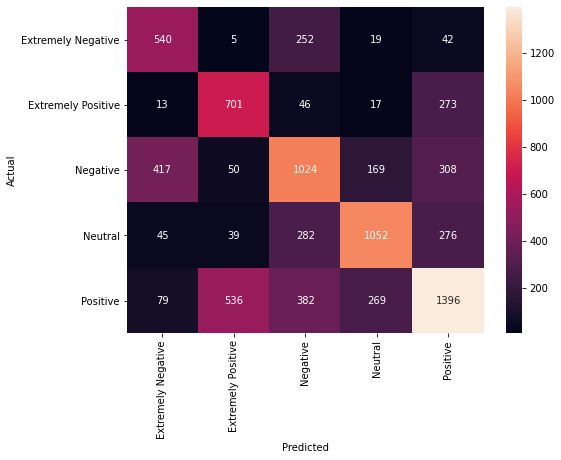

In [67]:
model_logistic.fit(X_train, y_train)
y_pred = model_logistic.predict(X_test)
print("Accurary:", metrics.accuracy_score(y_test,y_pred))
monta_confusion_matrix(y_pred, y_test)

In [ ]:
print("Accurary:", metrics.accuracy_score(y_test,y_pred))
monta_confusion_matrix(y_pred, y_test)

### Random Forest

In [51]:
 model_rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)

In [52]:
entries=[]
accuracies = cross_val_score(model_rf, tf_idf_vet, labels, scoring='accuracy', cv=5)


NameError: name 'model_name' is not defined

In [55]:
entries=[]
for fold_idx, accuracy in enumerate(accuracies):
    entries.append(('RF', fold_idx, accuracy))
entries

[('RF', 0, 0.29312439261418854),
 ('RF', 1, 0.287779397473275),
 ('RF', 2, 0.285991981533228),
 ('RF', 3, 0.2850200461669299),
 ('RF', 4, 0.2801603693354392)]